In [121]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# 데이터셋 생성

In [122]:
import os

target = 'Car'

folders = os.listdir('./images')
folders.remove(target)
folders.remove('Other')

files = os.listdir(f'./images/{target}')
length = len(files)

X = np.empty((length*2, 120, 120, 3))
Y = np.empty((length*2,))

for i in range(length):
    x = cv2.imread(f"./images/{target}/{files[i]}")
    X[i] = cv2.resize(x, (120, 120))
    Y[i] = 1

for f in range(7):
    files = os.listdir(f'./images/{folders[f]}')
    for i in range(length//10):
        x = cv2.imread(f"./images/{folders[f]}/{files[i]}")
        X[length + length//10*f + i] = cv2.resize(x, (120, 120))
        Y[length + length//10*f + i] = 0

files = os.listdir('./images/Other')
for i in range(length - length//10*7):
    x = cv2.imread(f"./images/Other/{files[i]}")
    X[i+length+length//10*7] = cv2.resize(x, (120, 120))
    Y[i+length+length//10*7] = 0

X /= 255


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)

In [124]:
print(X_train.shape)
print(X_test.shape)
print( y_train.shape)
print(y_test.shape)

(5337, 120, 120, 3)
(1779, 120, 120, 3)
(5337,)
(1779,)


# 모델 생성

In [125]:
model = Sequential()
model.add(Conv2D(64, (7,7), activation='relu', padding="same", input_shape=(120, 120, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(64, (5,5), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

In [126]:
model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=[
        'accuracy',
    ],
)

In [127]:
modelpath=f"./history/{target.lower()}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=10)

In [128]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=64, verbose='auto', callbacks=[early_stopping_callback,checkpointer])

Epoch 1/50
67/67 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.5601
Epoch 1: val_accuracy improved from -inf to 0.54120, saving model to ./history\car.hdf5
67/67 [==============================] - 295s 4s/step - loss: 1.0536 - accuracy: 0.5601 - val_loss: 1.1087 - val_accuracy: 0.5412
Epoch 2/50
67/67 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.5659
Epoch 2: val_accuracy improved from 0.54120 to 0.55056, saving model to ./history\car.hdf5
67/67 [==============================] - 267s 4s/step - loss: 0.7312 - accuracy: 0.5659 - val_loss: 2.7601 - val_accuracy: 0.5506
Epoch 3/50
67/67 [==============================] - ETA: 0s - loss: 0.7023 - accuracy: 0.5737
Epoch 3: val_accuracy did not improve from 0.55056
67/67 [==============================] - 276s 4s/step - loss: 0.7023 - accuracy: 0.5737 - val_loss: 0.8733 - val_accuracy: 0.5421
Epoch 4/50
67/67 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.6107
Epoc

In [129]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

56/56 [==============================] - 29s 519ms/step - loss: 1.8584 - accuracy: 0.7178


[1.8583623170852661, 0.7178189754486084]

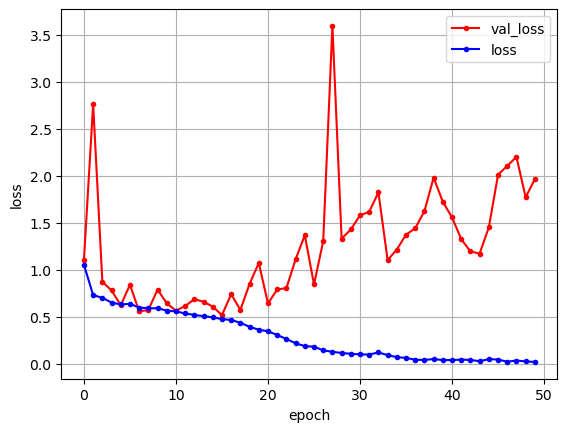

In [130]:
val_loss = history.history['val_loss']
loss = history.history['loss']

x_len = np.arange(len(loss))
plt.plot(x_len, val_loss, marker='.', c="red", label='val_loss')
plt.plot(x_len, loss, marker='.', c="blue", label='loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

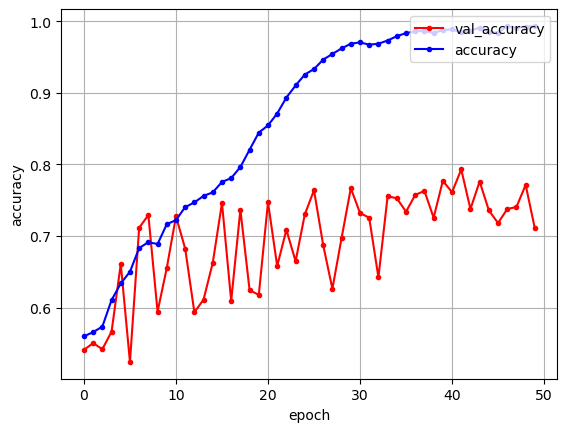

In [131]:
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

x_len = np.arange(len(accuracy))
plt.plot(x_len, val_accuracy, marker='.', c="red", label='val_accuracy')
plt.plot(x_len, accuracy, marker='.', c="blue", label='accuracy')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [132]:
model.save(f"./models/{target.lower()}.hdf5")